In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from networkx.algorithms import community


In [4]:
raw_data = pd.read_csv('all_data_raw.csv',index_col=0)
# raw_data

In [5]:
raw_data['month'] = raw_data.apply(lambda x:x['日期'][:-3],axis=1)
raw_data['year'] = raw_data.apply(lambda x:x['日期'][:-6],axis=1)
raw_data['return'] = np.log(raw_data['收盘价(元)'])-np.log(raw_data['开盘价(元)'])

In [6]:
mutiIndex = list(zip(raw_data['month'],raw_data['简称']))
index = pd.MultiIndex.from_tuples(mutiIndex,names=['month','简称'])
raw_data.set_index(index)
raw_data.to_csv('cleaned_data.csv')

In [7]:
one_month = raw_data[raw_data['month']=='2010-02']
# one_month[one_month['简称']=='中信证券']

In [8]:
pivot_m = pd.pivot_table(data=one_month,values='return',columns='简称',index='日期')
# pivot_m

In [9]:
corr=pivot_m.corr()
# corr

In [10]:
print(sum(np.sum(corr.isna())))

236


In [11]:
distance_m = np.sqrt(2*(1-corr))
# distance_m

In [12]:
zipped = []
for i in range(len(distance_m.columns)):
    zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
List_flat = []
for i in zipped:
    for j in i:
        # print(j)
        # print(type(j[2]))
        if not np.isnan(j[2]):
            # print(j[2])
            List_flat.append(j)
s_List_flat = list(set(List_flat))
G = nx.Graph()
node_list = list([x for x,y,z in s_List_flat])
for i in range(len(node_list)):
    G.add_node(node_list[i])
G.add_weighted_edges_from(s_List_flat)

In [13]:
print(nx.number_of_edges(G))
print(nx.number_of_nodes(G))

1711
58


In [14]:
mst = nx.minimum_spanning_tree(G=G)

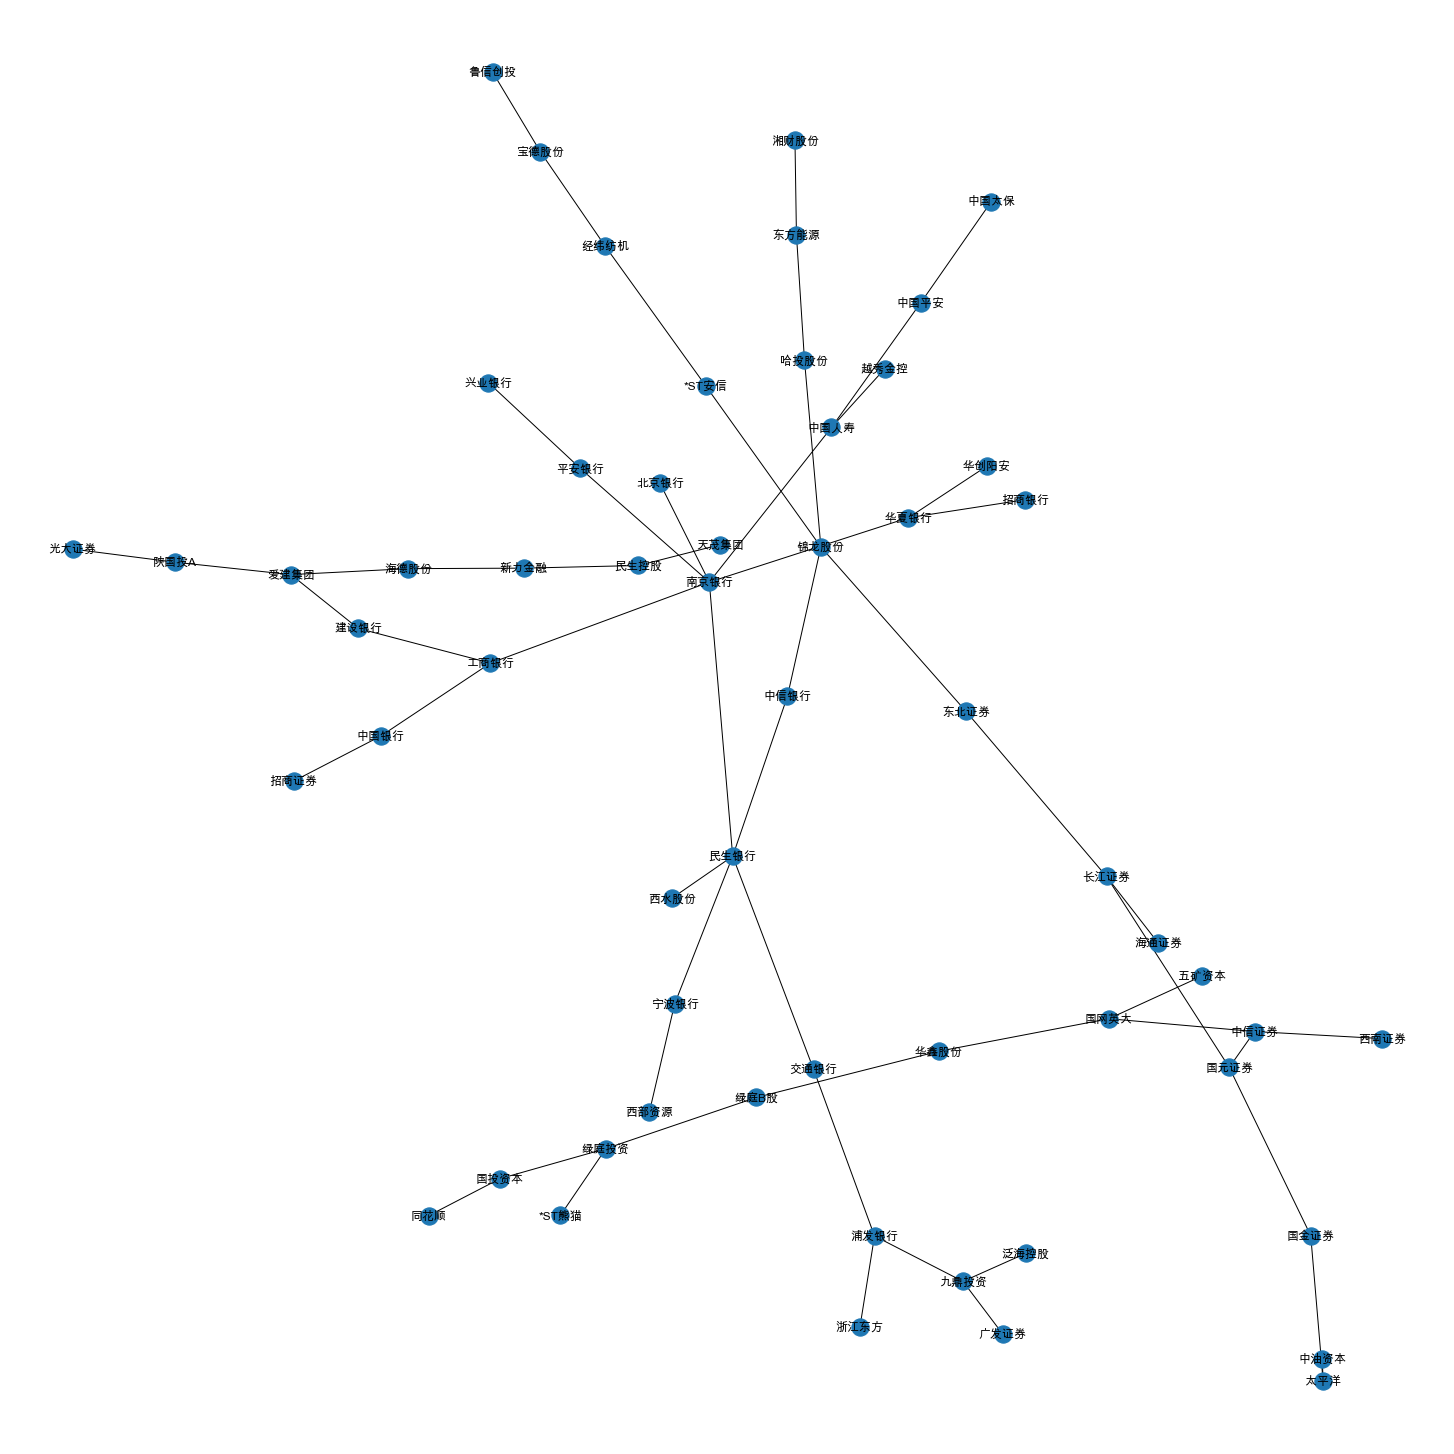

In [15]:
plt.figure(figsize=(20,20))

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_spring(mst,with_labels=True,)

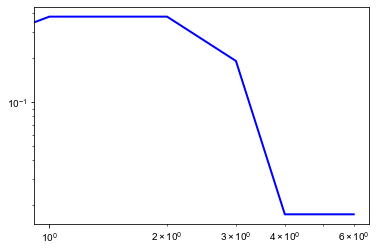

In [16]:
degree =  nx.degree_histogram(mst)          
x = range(len(degree))                             
y = [z / float(sum(degree)) for z in degree] 
plt.loglog(x,y,color="blue",linewidth=2)          
plt.show()                                                          

In [17]:
communities_generator = community.girvan_newman(mst)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
color_c = sorted(map(sorted, next_level_communities))
print(len(color_c))

3


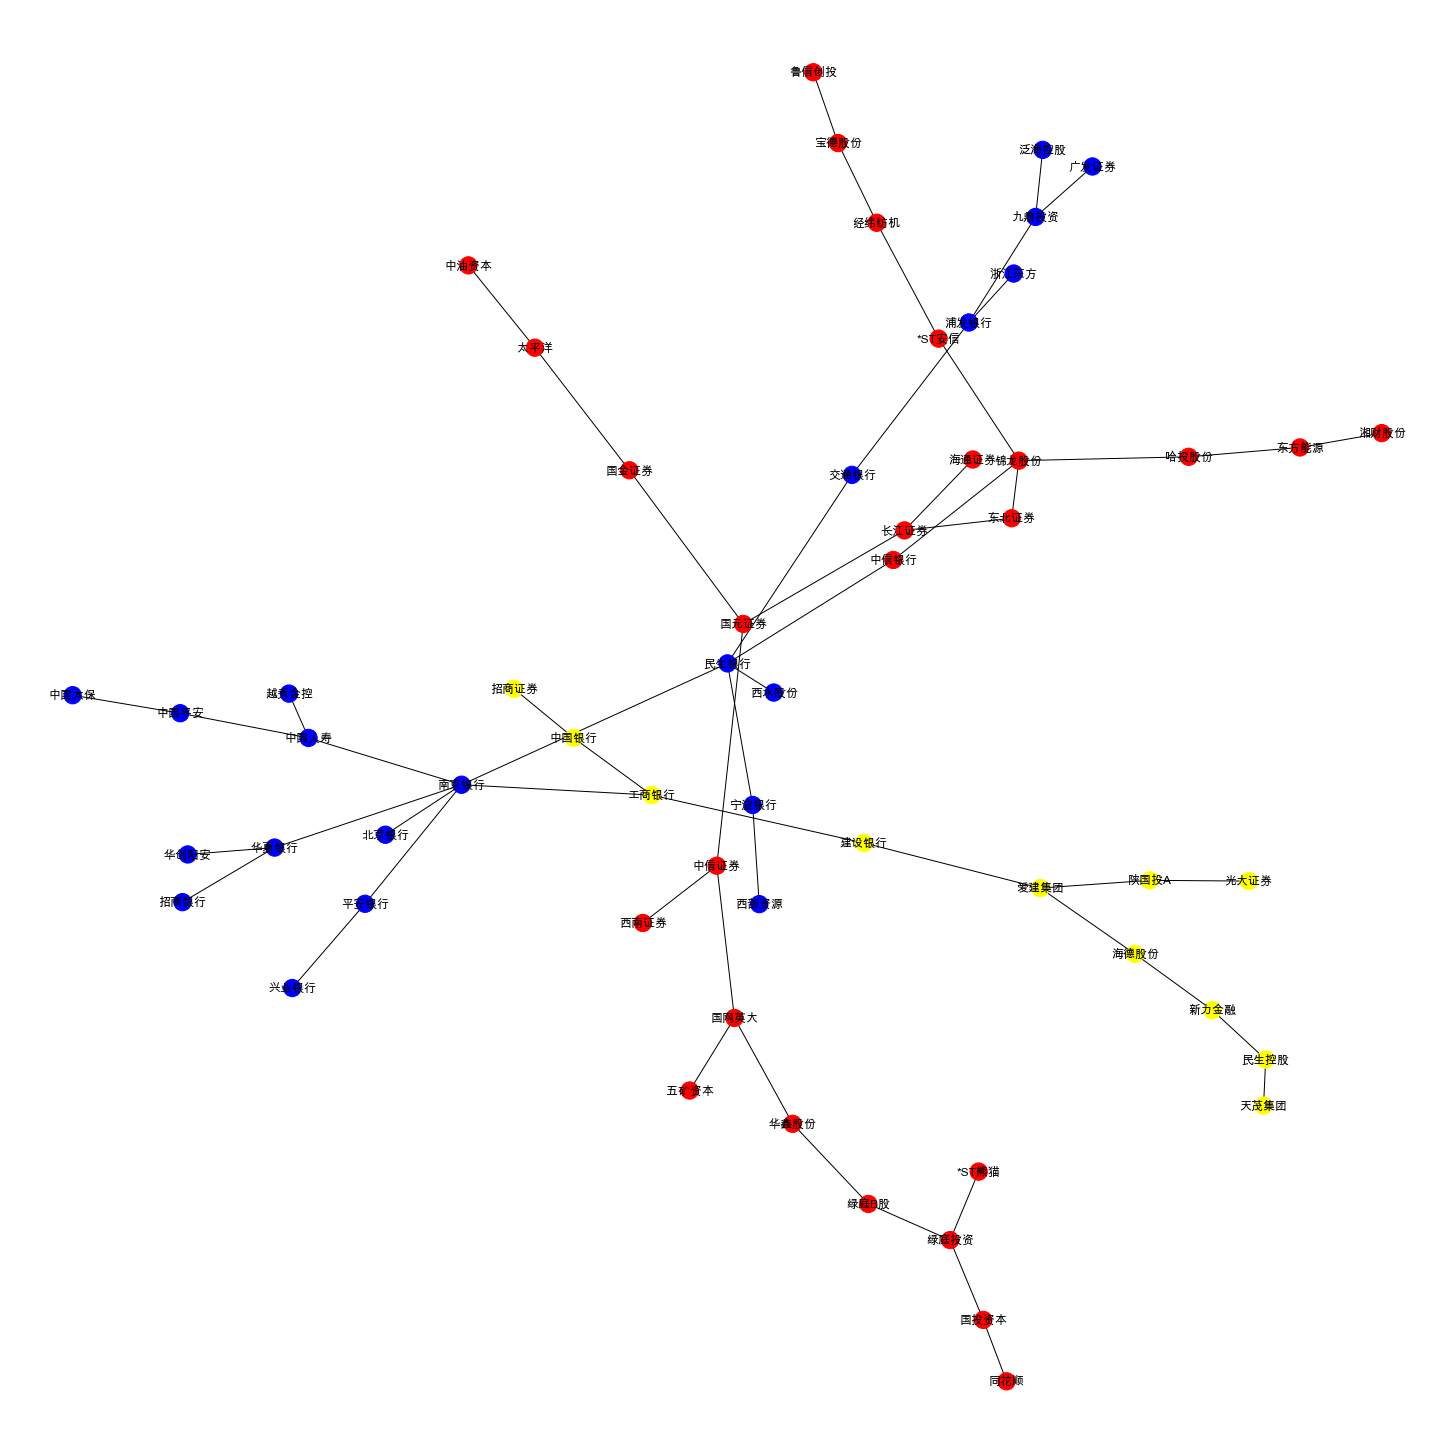

In [18]:
color = ['red','blue','yellow','green']
color_map = []
for node in mst:
    # print(node)
    if node in color_c[0]:
        color_map.append(color[0])
    elif node in color_c[1]:
        color_map.append(color[1])
    else:
        color_map.append(color[2])        
plt.figure(figsize=(20,20))
nx.draw_spring(mst,node_color = color_map,with_labels = True)

In [19]:
# nx.write_gexf(mst,'mst_2010_11.gexf')

In [20]:
import planarity

def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True),
                                     key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges
def compute_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG

In [21]:
sorted_edges = sort_graph_edges(G)
print(len(sorted_edges))

1711


In [29]:
start = time.time()
PMFG = compute_PMFG(sorted_edges, len(G.nodes))
end = time.time()
print('time used: ', end-start)
print('# nodes :', nx.number_of_nodes(PMFG))

time used:  0.014971733093261719
# nodes : 58


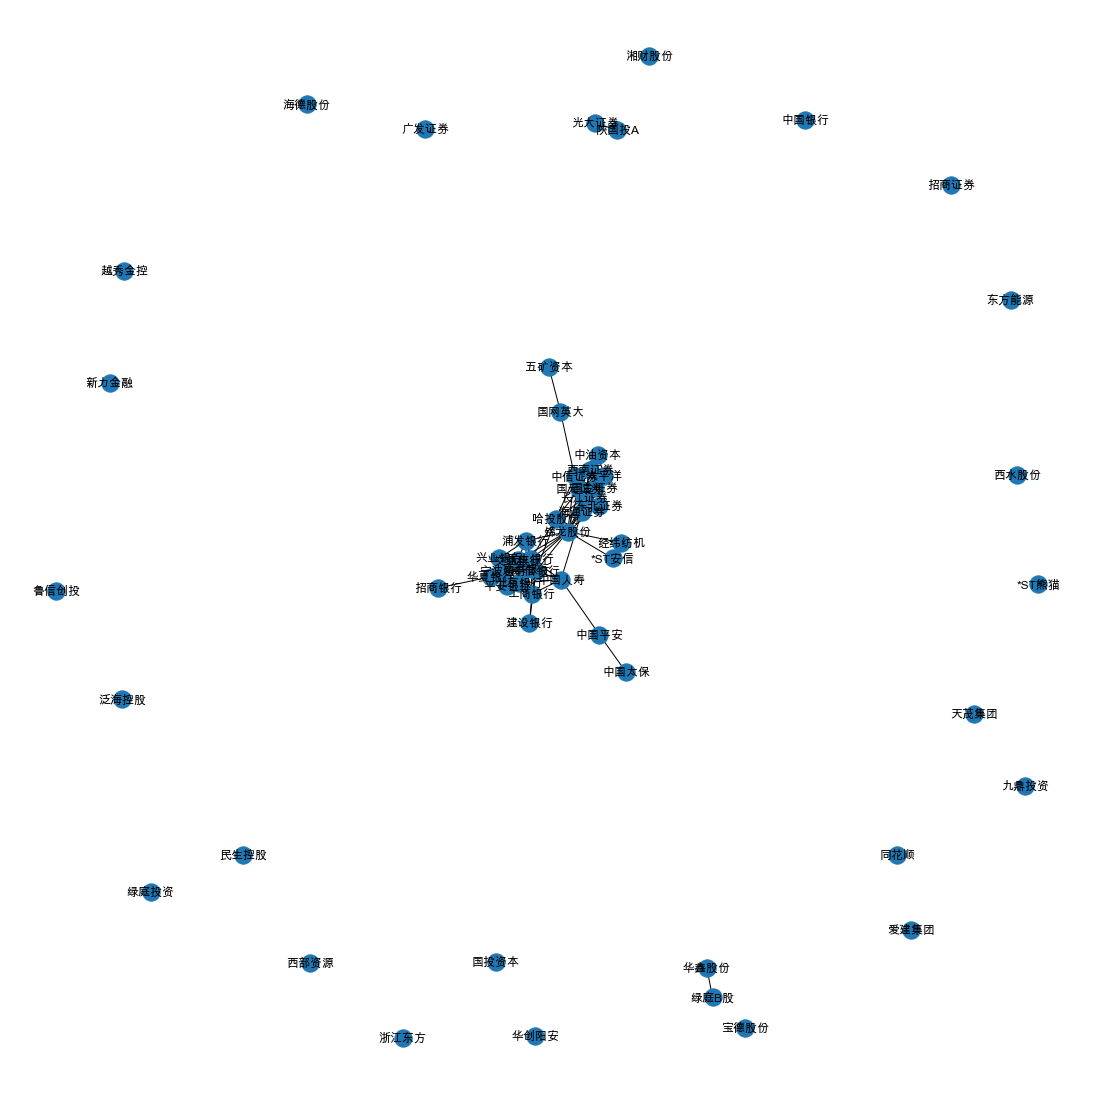

In [28]:
plt.figure(figsize=(15,15))
nx.draw(PMFG,with_labels=True)


In [24]:
# def compute_PMFG(sorted_edges, nb_nodes):
#     PMFG = nx.Graph()
#     for edge in sorted_edges:
#         PMFG.add_edge(edge['source'], edge['dest'])
#         if not planarity.is_planar(PMFG):
#             PMFG.remove_edge(edge['source'], edge['dest'])
            
#         if len(PMFG.edges()) == 3*(nb_nodes-2):
#             break
    
#     return PMFG

In [31]:
S = [PMFG.subgraph(c).copy() for c in nx.connected_components(PMFG)]

In [32]:
S

In [33]:
largest_cc = max(nx.connected_components(PMFG), key=len)

In [34]:
largest_cc

{'*ST安信',
 '东北证券',
 '中信证券',
 '中信银行',
 '中国人寿',
 '中国太保',
 '中国平安',
 '中油资本',
 '五矿资本',
 '交通银行',
 '兴业银行',
 '北京银行',
 '华夏银行',
 '南京银行',
 '哈投股份',
 '国元证券',
 '国网英大',
 '国金证券',
 '太平洋',
 '宁波银行',
 '工商银行',
 '平安银行',
 '建设银行',
 '招商银行',
 '民生银行',
 '浦发银行',
 '海通证券',
 '经纬纺机',
 '西南证券',
 '锦龙股份',
 '长江证券'}